## Evaluating classification techniques for speaker characterization
### Laura Fernández Gallardo

In this notebook, I will evaluate the performance of different classification techniques for characterizing users' warmth-attractiveness (WAAT). 

* Thesholding continuous scores generated from [factor analysis](https://github.com/laufergall/Subjective_Speaker_Characteristics/tree/master/speaker_characteristics/factor_analysis) based on percentiles to define 3 classes ("high", "mid", and "low") with approximately the same number of samples.
* Only the "high" and "low" classes are of interest -> I address **binary classification**.
* As evaluation metric, I will consider the average per-class accuracy (average of sensitivity and specificity)

In [1]:
import io
import requests
import time # for timestamps
import pickle # save models

import numpy as np
import pandas as pd
from ast import literal_eval # parsing hp after tuner

from cls_tuning import * # my helper functions

from sklearn.metrics import recall_score, classification_report, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Speakers' WAAT

WAAT (warmth-attractiveness) can be seen as the first two dimensions of the perceived speaker characteristics. Scaled scores (with mean = 0 and std = 1) of speakers on these dimensions were already extracted in the [subjective analysis](https://github.com/laufergall/Subjective_Speaker_Characteristics), for males and for females separately.


In [3]:
# load WAAT scores (averaged across listeners)

path = "https://raw.githubusercontent.com/laufergall/Subjective_Speaker_Characteristics/master/data/generated_data/"

url = path + "factorscores_malespk.csv"
s = requests.get(url).content
scores_m =pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "factorscores_femalespk.csv"
s = requests.get(url).content
scores_f =pd.read_csv(io.StringIO(s.decode('utf-8')))

# rename dimensions
scores_m.columns = ['sample_heard', 'warmth', 'attractiveness', 'confidence', 'compliance', 'maturity']
scores_f.columns = ['sample_heard', 'warmth', 'attractiveness', 'compliance', 'confidence', 'maturity']

# join male and feame scores
scores = scores_m.append(scores_f)
scores['gender'] = scores['sample_heard'].str.slice(0,1)
scores['spkID'] = scores['sample_heard'].str.slice(1,4).astype('int')

scores.head()

,attractiveness,compliance,confidence,maturity,sample_heard,warmth,gender,spkID
0,-0.579301,-0.921918,0.608503,0.276580,m004_linden_stimulus.wav,-0.284638,m,4
1,0.442865,-0.950212,0.588889,0.630295,m005_nicosia_stimulus.wav,-0.494019,m,5
2,-0.507534,0.139302,-0.151077,-0.669449,m006_rabat_stimulus.wav,1.533478,m,6
3,1.180748,-0.108982,0.962166,1.026359,m007_klaksvik_stimulus.wav,0.478983,m,7
4,1.070247,-0.284278,-0.875589,-1.291311,m016_beirut_stimulus.wav,1.861551,m,16


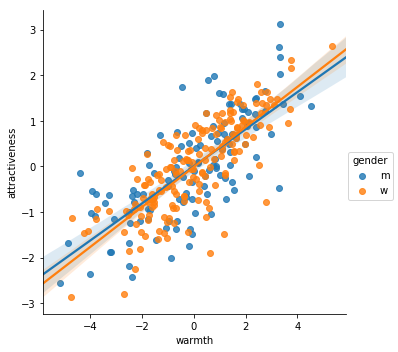

In [4]:
# scatter plot

sns.lmplot('warmth', 'attractiveness', data = scores, hue="gender") 

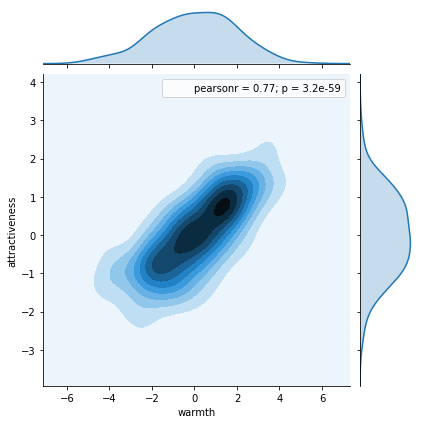

In [5]:
# histogram, kernel density estimation
sns.jointplot('warmth', 'attractiveness', data = scores, kind="kde").set_axis_labels("warmth", "attractiveness")

Get 3 clusters of speakers based on the WAAT distribution.
Each cluster with approx. the same number of instances.

mid     117
high    104
low      79
Name: class, dtype: int64


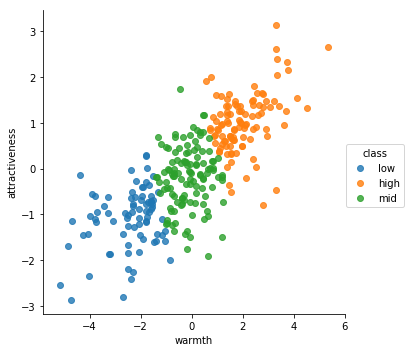

In [10]:
# applying k-means

n_clusters=3

kmeans = KMeans(n_clusters=n_clusters, random_state=2302).fit(scores[['warmth','attractiveness']])

scores['class'] = pd.Categorical(kmeans.labels_).rename_categories(['low','high','mid'])

print(scores['class'].value_counts())   

myfig = sns.lmplot('warmth', 'attractiveness', data = scores, hue="class", fit_reg=False, aspect=1)
filename = r'\kmeans3_WAAT_allspeakers.png'
myfig.savefig(r'.\figures' + filename, bbox_inches = 'tight')  


**Removing** speakers in the mid class to address binary classification.

**Split speakers** into train (75%) and test (25%) speakers with class and gender balance (stratified) by creating the dummy "gendertrait" class.

In [8]:
# remove speakers in the mid class

scores = scores.loc[ scores['class'] != 'mid', ['spkID','gender','class']]

scores['class'] = pd.Categorical(scores['class'], categories=['low','high'])

print(scores.head())

print(scores.groupby(['gender','class']).count())

    spkID gender class
2       6      m  high
4      16      m  high
7      20      m   low
9      22      m   low
10     23      m   low
              spkID
gender class       
m      low       34
       high      46
w      low       45
       high      58


In [10]:
# get stratified random partition for train and test

scores['genderclass']=scores[['gender', 'class']].apply(lambda x: ''.join(x), axis=1)

indexes = np.arange(0,len(scores))
classes = scores['class']
train_i, test_i, train_y, test_y = train_test_split(indexes, 
                                                    classes, 
                                                    test_size=0.25, 
                                                    stratify = scores['genderclass'], 
                                                    random_state=2302)

scores_train = scores.iloc[train_i,:] 
scores_test = scores.iloc[test_i,:] 

print('Number of speakers in Train:',len(scores_train))
print('Number of speakers in Test:',len(scores_test))

print('Number of w-high speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='whigh']) )
print('Number of m-high speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='mhigh']) )
print('Number of w-low speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='wlow']) )
print('Number of m-high speakers in Train:', len(scores_train.loc[scores_train['genderclass']=='mlow']) )

print('Number of w-high speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='whigh']) )
print('Number of m-high speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='mhigh']) )
print('Number of w-low speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='wlow']) )
print('Number of m-low speakers in Test:', len(scores_test.loc[scores_test['genderclass']=='mlow']) )


# save these data for other evaluations
scores.iloc[:,0:3].to_csv(r'..\data\generated_data\speakerIDs_cls_WAAT_all.csv', index=False)
scores_train.iloc[:,0:3].to_csv(r'..\data\generated_data\speakerIDs_cls_WAAT_train.csv', index=False)
scores_test.iloc[:,0:3].to_csv(r'..\data\generated_data\speakerIDs_cls_WAAT_test.csv', index=False)

Number of speakers in Train: 137
Number of speakers in Test: 46
Number of w-high speakers in Train: 43
Number of m-high speakers in Train: 34
Number of w-low speakers in Train: 34
Number of m-high speakers in Train: 26
Number of w-high speakers in Test: 15
Number of m-high speakers in Test: 12
Number of w-low speakers in Test: 11
Number of m-low speakers in Test: 8


## Speech features

Speech features have been extracted from the semi-spontaneous dialogs uttered by the 300 speakers of the [NSC corpus](http://www.qu.tu-berlin.de/?id=nsc-corpus). 

Each semi-spontaneous dialog was splitted into 3 segments of approx. 20s, and the 88 [eGeMAPS](http://ieeexplore.ieee.org/document/7160715/) speech features were extracted from each segment (see ..\feature_extraction).

299 speakers recorded 4 semi-spontaneous dialogs, and 1 female speaker recorded 1 semi-spontaneous dialog. Total = 1197 dialogs * 3 segments = 3591 speech files.

Unfortunately, no subjective ratings have been collected for the spontaneous dialogs d5, d7, or d8. However, we use the speech features in order to have more instances with which to train and test the models.

**I assume** that the speakers' trait classes remain constant across recordings, that is, is a speaker is perceived as 'high' in the _intelligent_ trait for dialog 6 (d6, pizza dialog), then this perception would be the same for the other dialogs uttered by the same speaker.

In [ ]:
# load speech features

path = "https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/extracted_features/"

url = path + "/eGeMAPSv01a_semispontaneous_splitted.csv"
s = requests.get(url).content
feats =pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ';') # shape: 3591, 89

feats.describe()

Pre-processing features with the transformation **learnt with training data**:

* center and scale speech features

In [ ]:
# Separate instances according to the train and test partition
# instances corresponding to speakers in the mid class will be left out

# extract speaker ID from speech file name
feats['spkID'] = feats['name'].str.slice(2, 5).astype('int')

# appending class label
feats_class_train = pd.merge(feats, scores_train[['spkID','genderclass','class']], how='inner')
feats_class_test = pd.merge(feats, scores_test[['spkID','genderclass','class']], how='inner')

print('Number of high instances in Train:', len(feats_class_train.loc[feats_class_train['class']=='high']) )
print('Number of low instances in Train:', len(feats_class_train.loc[feats_class_train['class']=='low']) )
print('Number of high instances in Test:', len(feats_class_test.loc[feats_class_test['class']=='high']) )
print('Number of low instances in Test:', len(feats_class_test.loc[feats_class_test['class']=='low']) )

feats_class_train.head()

# save feature names
dropcolumns=['name','spkID','genderclass','class']
feats_names = list(feats_class_train.drop(dropcolumns, axis=1))

myfile = open(r'.\data_while_tuning\feats_names.csv', 'w')
for item in feats_names:
    myfile.write("%r\n" % item)

In [ ]:
# Standardize speech features  

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_class_train.drop(dropcolumns, axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_class_train.drop(dropcolumns, axis=1))
feats_s_test = scaler.transform(feats_class_test.drop(dropcolumns, axis=1)) 

## Model tuning with feature selection

Use the train data to find the classifier and its hyperparameters leading to the best performance. 

Perform feature selection with "SelectKBest": selecting best k features based on ANOVA F-value computed between class label and feature. 

My procedure:

* Choose data (feature and labels) for train X and y and test Xt and yt
* Split train data into A and B sets
* Hyperparameter tuner using A and B sets data by calling hp_tuner()
    * For each classifier type:
        * Stratified cross-validation for hyperparameter tuning using set A
        * Evaluate the performance on set B
* Select classifier based on the best performance on set B and train it using all training data   
* Get performance on test set

(Nested hyperparameter tuning inspired by [A. Zheng](http://www.oreilly.com/data/free/evaluating-machine-learning-models.csp))

(hp_tuner() in cls_tuning.py)

In [ ]:
# training data. Features and labels
X = feats_s_train
y = feats_class_train['class'].cat.codes

# test data. Features and labels
Xt = feats_s_test
yt = feats_class_test['class'].cat.codes

# split train data into 80% and 20% subsets - with balance in trait and gender
# give subset A to the inner hyperparameter tuner
# and hold out subset B for meta-evaluation
AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_class_train['genderclass'], random_state=2302)

print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
print('Number of instances in B (meta-evaluation):',BX.shape[0])
    

In [10]:
# dataframe with results from hp tuner to be appended
tuning_all = pd.DataFrame()

# list with tuned classifiers trained on training data, to be appended
trained_all = []

In [ ]:
# save splits

# original features and class
feats_class_train.to_csv(r'.\data_while_tuning\feats_class_train.csv', index=False)
feats_class_test.to_csv(r'.\data_while_tuning\feats_class_test.csv', index=False)

# train/test partitions, features and labels
np.save(r'.\data_while_tuning\X.npy', X)
np.save(r'.\data_while_tuning\y.npy', y)
np.save(r'.\data_while_tuning\Xt.npy', Xt)
np.save(r'.\data_while_tuning\yt.npy', yt)

# # A/B splits, features and labels
np.save(r'.\data_while_tuning\AX.npy', AX)
np.save(r'.\data_while_tuning\BX.npy', BX)
np.save(r'.\data_while_tuning\Ay.npy', Ay)
np.save(r'.\data_while_tuning\By.npy', By)

### Calling hp_tuner() for each classifier

** Recover ** when new ipynb session started.

(Workaround for working with hyperparameter tuning during several days)

In [3]:

# original features and class
feats_class_train = pd.read_csv(r'.\data_while_tuning\feats_class_train.csv')
feats_class_test = pd.read_csv(r'.\data_while_tuning\feats_class_test.csv')
feats_names = pd.read_csv(r'.\data_while_tuning\feats_names.csv', header=None)
feats_names = feats_names.values.tolist()

# train/test partitions, features and labels
X = np.load(r'.\data_while_tuning\X.npy')
y = np.load(r'.\data_while_tuning\y.npy')
Xt = np.load(r'.\data_while_tuning\Xt.npy')
yt = np.load(r'.\data_while_tuning\yt.npy')

# A/B splits, features and labels
AX = np.load(r'.\data_while_tuning\AX.npy')
BX = np.load(r'.\data_while_tuning\BX.npy')
Ay = np.load(r'.\data_while_tuning\Ay.npy')
By = np.load(r'.\data_while_tuning\By.npy')


In [5]:
# Loading outpus of hp tuning from disk
tuning_all, trained_all = load_tuning()

Call this after each experiment **to recover later**:

In [32]:
# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all)

#### GaussianNB

*class sklearn.naive_bayes.GaussianNB(priors=None)*

No parameters to tune for this classifier. Priors not specified, so they will be adjusted given the data.

In [14]:
from sklearn.naive_bayes import GaussianNB

"""
Naive Bayes Classifier
"""
def get_GaussianNB2tune():

    model = GaussianNB()
    hp = dict()
    return 'GaussianNB', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_GaussianNB2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'GaussianNB' -> Best cross-val score on A set: 0.685354 using {'selecter__k': 37}
'GaussianNB' -> Selected features: []
'GaussianNB' -> Average per-class accuracy on B set: 0.690090



0     {'selecter__k': 2}
1     {'selecter__k': 7}
2    {'selecter__k': 12}
3    {'selecter__k': 17}
4    {'selecter__k': 22}
Name: params, dtype: object


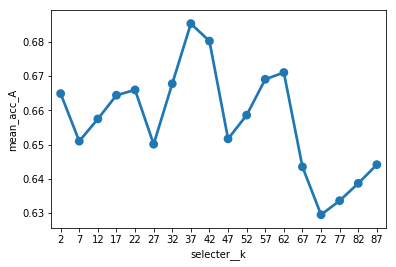

In [15]:
# open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\GaussianNB_tuning.csv')
print(sgrid['params'].head())

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. k
sns.pointplot(x='selecter__k', y='mean_acc_A', data=sgrid.join(params_df)) 

Not so good performance with naive bayes, and no trend can be seen to detect which number of selected features is better.

#### LogisticRegression

*class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)*

Tuning C (inverse of regularization strength). The 'liblinear' solver (a good choice for small datasets) handles L1 penalty.


In [16]:
from sklearn.linear_model import LogisticRegression

"""
Logistic Regression
"""
def get_LogisticRegression2tune():

    model = LogisticRegression()
    hp = dict(
        #classifier__penalty = ['l1','l2'],
        classifier__C = np.logspace(-3,3,num=7)
    )
    return 'LogisticRegression', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_LogisticRegression2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'LogisticRegression' -> Best cross-val score on A set: 0.756037 using {'classifier__C': 10.0, 'selecter__k': 87}
'LogisticRegression' -> Selected features: ["'F0semitoneFrom27.5Hz_sma3nz_amean'"]
'LogisticRegression' -> Average per-class accuracy on B set: 0.753022



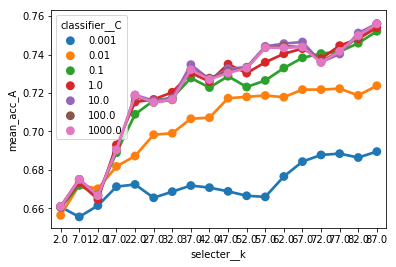

In [17]:
# open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\LogisticRegression_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df)) 

Including more features is beneficial for the performance of logistic regression. Similar behavior when C >= 0.1

#### K Nearest Neighbors

*class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)*

Tuning number of neighbors.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

"""
K Nearest Neighbors
"""
def get_KNeighborsClassifier2tune():

    model = KNeighborsClassifier()
    hp = dict(
        classifier__n_neighbors = list(range(1,40))
    )
    return 'KNeighborsClassifier', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_KNeighborsClassifier2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'KNeighborsClassifier' -> Best cross-val score on A set: 0.901192 using {'classifier__n_neighbors': 4, 'selecter__k': 67}
'KNeighborsClassifier' -> Selected features: ["'F0semitoneFrom27.5Hz_sma3nz_amean'"]
'KNeighborsClassifier' -> Average per-class accuracy on B set: 0.870721



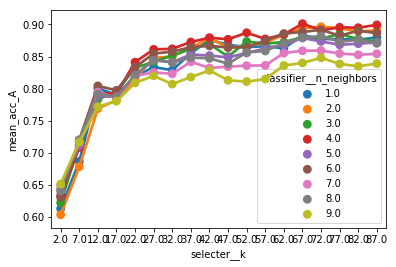

In [19]:
# open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\KNeighborsClassifier_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
params_df = params_df.loc[params_df['classifier__n_neighbors']<10,:] # selecting only lower k
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__n_neighbors', data=sgrid.join(params_df)) 

The performance of KNN classifiction tends to be better with more features with 6 neighbors or less.

#### Support Vector Machines

*class sklearn.svm.SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)*

I create a different function for each kernel. Tuning C (Penalty of the error term), degree (for 'poly' only), and gamma. 

In [6]:
from sklearn.svm import SVC

"""
Support Vector Machines
"""
def get_SVClinear2tune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.logspace(-5,3,num=9),
        classifier__kernel = ['linear']
    )
    return 'SVClinear', model, hp

def get_SVCpoly2tune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.logspace(-4,2,num=7),
        classifier__kernel = ['poly'],
        classifier__degree = [2,3,4,5], 
        classifier__gamma = ['auto']#,np.logspace(-5,2,num=8)]
    )
    return 'SVCpoly', model, hp

def get_SVCrbf2tune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.logspace(-5,5,num=20),
        classifier__kernel = ['rbf'],
        classifier__gamma = np.logspace(-5,5,num=20)
    )
    return 'SVCrbf', model, hp

def get_SVCsigmoid2tune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.logspace(-5,3,num=9),
        classifier__kernel = ['sigmoid'],
        classifier__gamma = np.logspace(-5,3,num=9)
    )
    return 'SVCsigmoid', model, hp


In [ ]:
# Hyperparameter tuning with SVM with different kernels
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_SVClinear2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

In [15]:
# tune with poly kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_SVCpoly2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all)

'SVCpoly' -> Best cross-val score on A set: 0.878826 using {'classifier__C': 10.0, 'classifier__degree': 3, 'classifier__gamma': 'auto', 'classifier__kernel': 'poly', 'selecter__k': 62}
'SVCpoly' -> Selected features: ["'F0semitoneFrom27.5Hz_sma3nz_amean'"]
'SVCpoly' -> Average per-class accuracy on B set: 0.850282



From now on, hyperparameter tuning with RandomizedSearchCV 

In [14]:
# tune with rbf kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_SVCrbf2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all)

'SVCrbf' -> Best cross-val score on A set: 0.749107 using {'selecter__k': 79, 'classifier__kernel': 'rbf', 'classifier__gamma': 0.00037926901907322499, 'classifier__C': 20.691380811147901}
'SVCrbf' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_amean'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile20.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile50.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_percentile80.0'"], ["'loudness_sma3_pctlrange0-2'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlope'"], ["'loudness_sma3_meanFallingSlope'"], ["'loudness_sma3_stddevFalli

In [7]:
# tune with sigmoid kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_SVCsigmoid2tune], feats_names)

# update lists of tuning info and trained classifiers
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameclassifier.sav)
save_tuning(tuning_all, trained_all)

'SVCsigmoid' -> Best cross-val score on A set: 0.734930 using {'selecter__k': 68, 'classifier__kernel': 'sigmoid', 'classifier__gamma': 1.0000000000000001e-05, 'classifier__C': 1000.0}
'SVCsigmoid' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_amean'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile50.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_pctlrange0-2'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlope'"], ["'loudness_sma3_meanFallingSlope'"], ["'loudness_sma3_stddevFallingSlope'"], ["'spectralFlux_sma3_stddevNorm'"], ["'mfcc1_sma3_amean'"], ["'mfcc1_sma3_

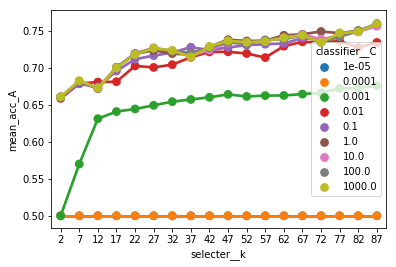

In [15]:
# Linear kernel: open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\SVClinear_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df)) 

In [18]:
# Poly kernel: open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\SVCpoly_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

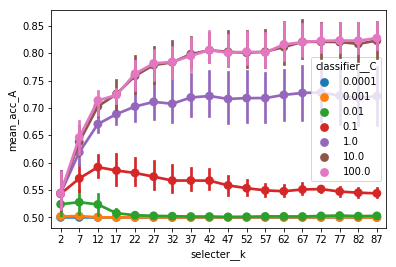

In [27]:
# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df))

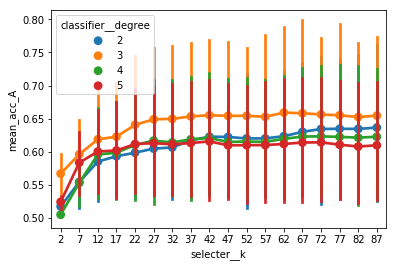

In [26]:
# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__degree', data=sgrid.join(params_df))

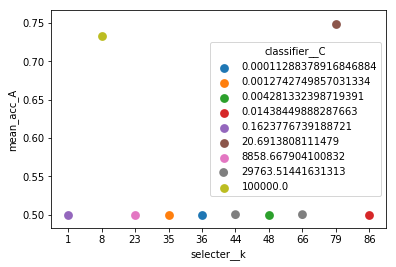

In [33]:
# rbf kernel: open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\SVCrbf_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df))

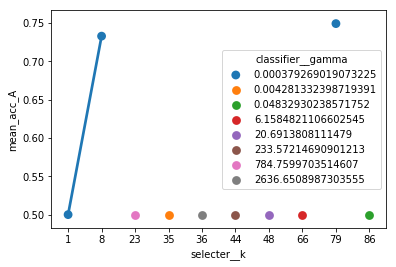

In [34]:

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__gamma', data=sgrid.join(params_df))

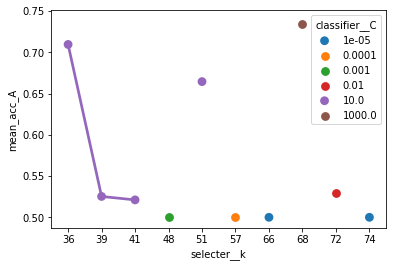

In [36]:
# sigmoid kernel: open generated file with results of fitting GridSearchCV
 
sgrid = pd.read_csv(r'.\data_while_tuning\SVCsigmoid_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='classifier__C', data=sgrid.join(params_df))

Parameters leading to better performance of SVC with different kernels:

* 'linear': C >= 0.1 and high number of features. Hp tuner selected C= 0.1 and k= 87. Performance on B = 0.74
* 'poly': C >= 10, degree = 3, and high number of features. Hp tuner selected C= 10, degree = 3, and k= 62. Performance on B = 0.85
* 'rbf': Hp tuner selected C= 20, gamma = 4e-4, and k= 79. Performance on B = 0.75
* 'sigmoid': Hp tuner selected C= 1e3, gamma = 1e-5, and k= 68. Performance on B = 0.73


Fine tuning of SVC with rbf kernel after the random search. Best C could be from 1 to 100, gamma around 1e-5 and 1e-3, and n features >=50.

In [ ]:
from sklearn.svm import SVC

def get_SVCrbf2finetune():
    
    model = SVC()
    hp = dict(
        classifier__C = np.arange(1,100,num=5),
        classifier__kernel = ['rbf'],
        classifier__gamma = np.logspace(-5,-3,num=3)
    )
    return 'SVCrbf', model, hp

k_gridsearch = np.arange(50, 88, 1)


tuning, trained = hp_finetuner(AX, BX, Ay, By, 
                               [get_SVCrbf2finetune], 
                               feats_names, 
                               k_gridsearch
                              )

# # update lists of tuning info and trained classifiers
# tuning_all = tuning_all.append(tuning, ignore_index=True)
# trained_all.append(trained)

# # save tuning_all (.csv) and trained_all (nameclassifier.sav)
# save_tuning(tuning_all, trained_all)


In [1]:
type(feats_names)

NameError: name 'feats_names' is not defined

In [ ]:
# # removing row
# tuning_all = tuning_all.drop(5)
# tuning_all = tuning_all.reindex(np.arange(0,len(tuning_all)))
# del trained_all[-1]
# len(trained_all)

#### DecisionTreeClassifier

*class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)*

In [ ]:
from sklearn.tree import DecisionTreeClassifier

"""
Decision Trees
"""
def get_DecisionTreeClassifier2tune():
    
    model = DecisionTreeClassifier()
    hp = dict(
        classifier__max_depth = np.arange(2,4)#np.arange(2,11)
    )
    return 'DecisionTreeClassifier', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_DecisionTreeClassifier2tune], feats_names)

# # update lists of tuning info and trained classifiers
# tuning_all = tuning_all.append(tuning, ignore_index=True)
# trained_all.append(trained)

#### RandomForestClassifier

*class sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

"""
Random Forest
"""
def get_RandomForestClassifier2tune():
    
    model = RandomForestClassifier()
    hp = dict(
        classifier__n_estimators = np.arange(2,4)#np.arange(2,51)
    )
    return 'RandomForestClassifier', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, [get_RandomForestClassifier2tune], feats_names)

# # update lists of tuning info and trained classifiers
# tuning_all = tuning_all.append(tuning, ignore_index=True)
# trained_all.append(trained)

In [ ]:
# select the classifier that gave the maximum acc on B set
best_accs = tuning_all['best_accs']
i_best = best_accs.idxmax()

print('Selected classifier based on the best performance on B: %r (accB = %0.2f)' % (tuning_all.loc[i_best,'classifiers_names'], round(best_accs[i_best],2)))

In [ ]:
# predictions on the test set 
# feat sel on Xt is performed by the classifier
yt_pred = trained_all[i_best][0].predict(Xt)

score_on_test = recall_score(yt, yt_pred, average='macro')

print("Average per-class accuracy on test: %f" % score_on_test) 

cm = confusion_matrix(yt, yt_pred)
print(classification_report(yt, yt_pred, digits = 2))
print(cm)
 